# [ EXPLORATION ] 16. 난 스케치를 할 테니 너는 채색을 하거라

✅이미지 생성 모델로 사용되는 GAN 중에서 조건이 추가된 CGAN에 대해 알아보고 Pix2Pix를 배워봅니다.

---
### - 📖목차
* ✔️16-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️16-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기
---
### (1) 데이터 준비하기

In [1]:
# 모듈 로드
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

In [2]:
# 경고 무시
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [3]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!ls '/content/gdrive/MyDrive/aiffel/ex_16'

cityscapes.zip	sketch2pokemon.zip  train  val


In [11]:
data_path = '/content/gdrive/MyDrive/aiffel/ex_16/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


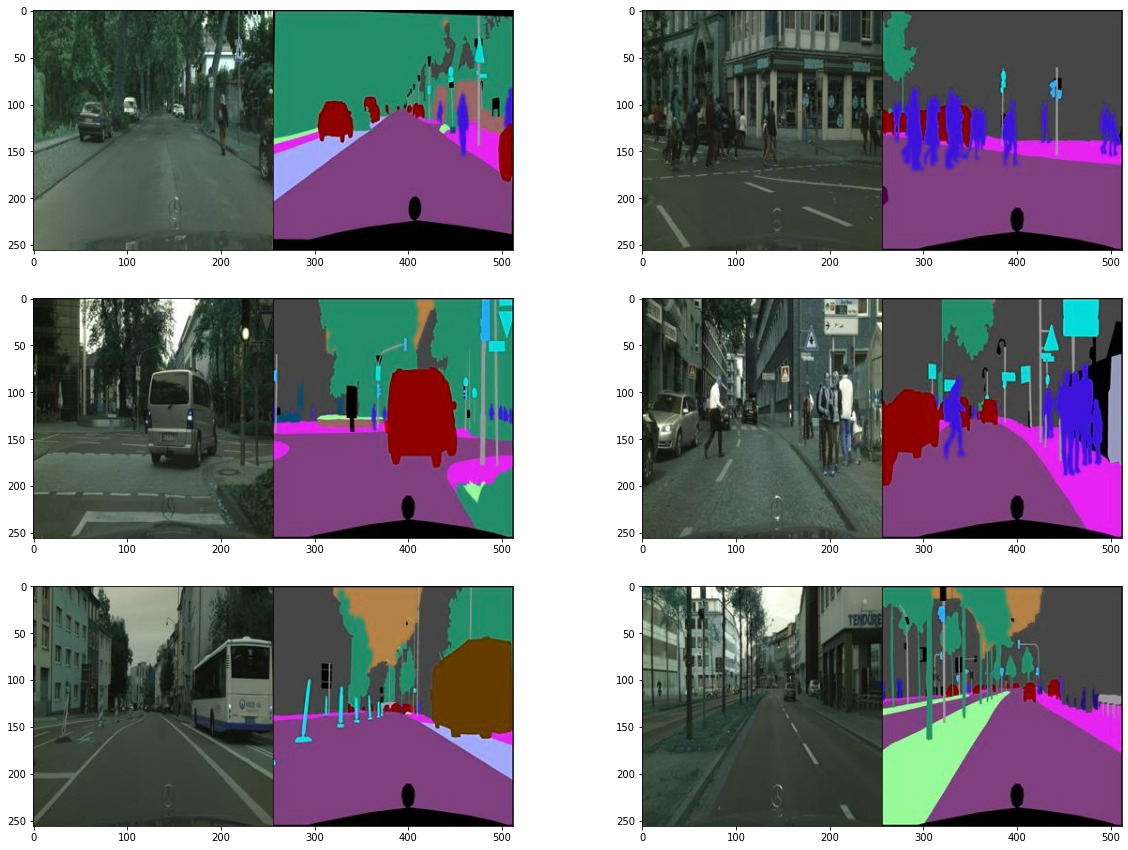

In [16]:
# 이미지 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [17]:
# 이미지 shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [18]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

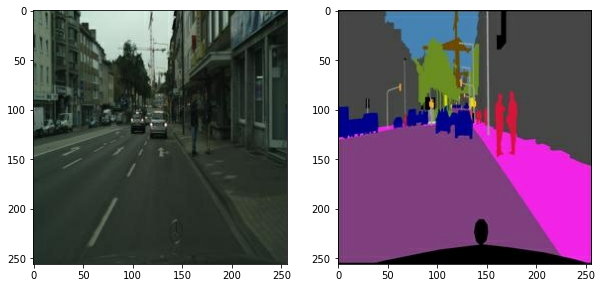

In [19]:
# 이미지 분리
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [20]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

# Augmentation 적용
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(sketch, colored):
    # 두 이미지를 채널 축으로 연결 (3채널인 경우 6채널로 변환)
    stacked = tf.concat([sketch, colored], axis=-1)

    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    # 50%의 확률로 Refection padding 또는 constant padding 적용
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 임의로 crop
    out = image.random_crop(padded, size=[256, 256, 6])

    # 50% 확률로 좌우상하 반전
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    # 50% 확률로 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)

    return out[...,:3], out[...,3:]

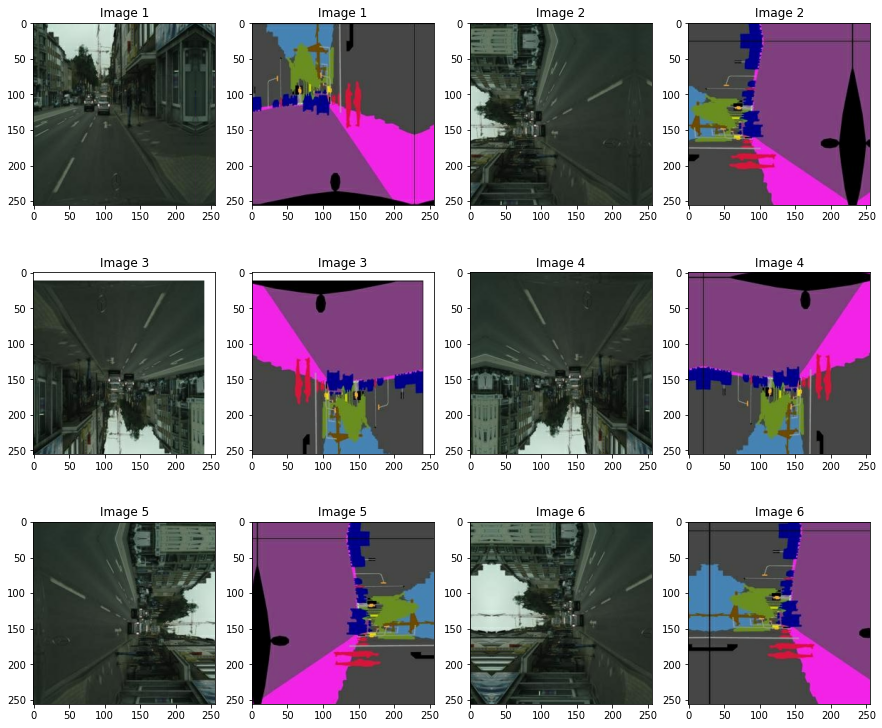

In [21]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [22]:
from tensorflow import data

# 학습 노드에서 sketch와 colored 순서가 다름에 주의
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

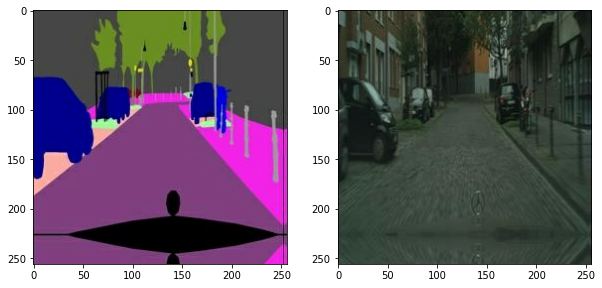

In [23]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

<br>

### (2) Generator 구성하기


In [24]:
# Encoder
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [25]:
# Decoder   
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

<br>

### (3) Generator 재구성하기

In [26]:
# U-Net Generator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # Encoder의 마지막 출력은 Decoder로 직접 입력되므로 Skip Connection에서 제외
        features = features[:-1]

        # feature의 역순으로 Skip Connection
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat]) # 가장 마지막 축(Channel) 기준으로 연결
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [27]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

<br>

### (4) Discriminator 구성하기

In [28]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            # 1 만큼 ZeroPadding
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [29]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [30]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

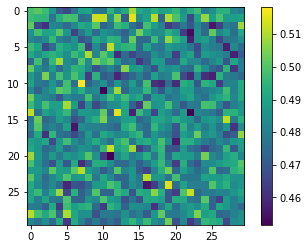

In [31]:
# 임의 테스트
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

<br>

### (5) 학습 및 테스트하기

In [32]:
# Loss Function
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [33]:
# Optimizer
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [34]:
# 학습 가중치 업데이트 함수
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [35]:
# 10 epoch 훈련
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9741                     
L1_loss:0.3129                     
Discriminator_loss:1.4389

EPOCH[1] - STEP[20]                     
Generator_loss:0.8513                     
L1_loss:0.2439                     
Discriminator_loss:1.3701

EPOCH[1] - STEP[30]                     
Generator_loss:0.8582                     
L1_loss:0.2109                     
Discriminator_loss:1.2873

EPOCH[1] - STEP[40]                     
Generator_loss:0.7986                     
L1_loss:0.1932                     
Discriminator_loss:1.2024

EPOCH[1] - STEP[50]                     
Generator_loss:0.8852                     
L1_loss:0.1700                     
Discriminator_loss:1.3790

EPOCH[1] - STEP[60]                     
Generator_loss:1.0097                     
L1_loss:0.1725                     
Discriminator_loss:1.1739

EPOCH[1] - STEP[70]                     
Generator_loss:1.0235                     
L1_loss:0.2160                    

In [36]:
val_path = '/content/gdrive/MyDrive/aiffel/ex_16/val/'
print("number of validation examples :", len(os.listdir(val_path)))

number of validation examples : 5


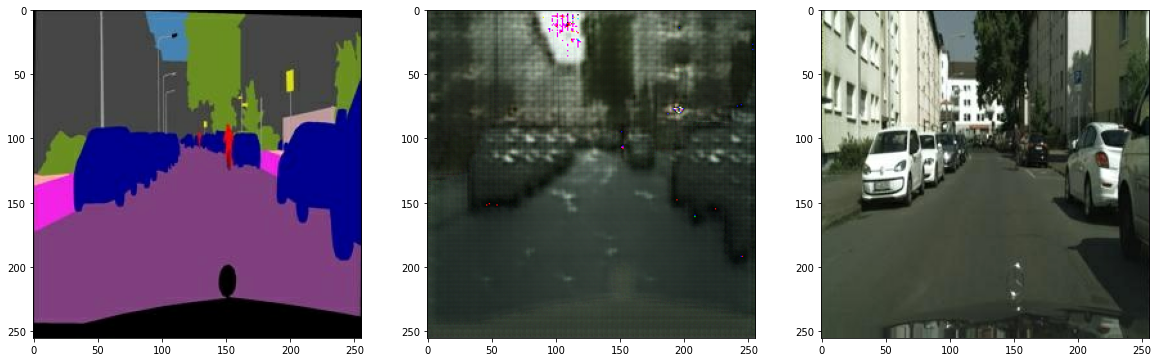

In [37]:
# 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [ ]:
# 추가 100 epochs train
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.5736                     
L1_loss:0.1537                     
Discriminator_loss:2.2409

EPOCH[1] - STEP[100]                     
Generator_loss:0.7850                     
L1_loss:0.2205                     
Discriminator_loss:0.7209

EPOCH[1] - STEP[150]                     
Generator_loss:1.6495                     
L1_loss:0.1905                     
Discriminator_loss:0.4512

EPOCH[1] - STEP[200]                     
Generator_loss:1.2811                     
L1_loss:0.2058                     
Discriminator_loss:0.5563

EPOCH[1] - STEP[250]                     
Generator_loss:1.0818                     
L1_loss:0.1371                     
Discriminator_loss:0.6891

EPOCH[2] - STEP[50]                     
Generator_loss:1.4799                     
L1_loss:0.1976                     
Discriminator_loss:0.4831

EPOCH[2] - STEP[100]                     
Generator_loss:0.8090                     
L1_loss:0.1752               

EPOCH[12] - STEP[100]                     
Generator_loss:0.6809                     
L1_loss:0.2120                     
Discriminator_loss:0.8865

EPOCH[12] - STEP[150]                     
Generator_loss:1.7765                     
L1_loss:0.1902                     
Discriminator_loss:0.7346

EPOCH[12] - STEP[200]                     
Generator_loss:1.7136                     
L1_loss:0.1751                     
Discriminator_loss:0.7816

EPOCH[12] - STEP[250]                     
Generator_loss:1.8280                     
L1_loss:0.1738                     
Discriminator_loss:1.0273

EPOCH[13] - STEP[50]                     
Generator_loss:1.4268                     
L1_loss:0.1818                     
Discriminator_loss:0.4093

EPOCH[13] - STEP[100]                     
Generator_loss:1.2589                     
L1_loss:0.1936                     
Discriminator_loss:0.4696

EPOCH[13] - STEP[150]                     
Generator_loss:0.8501                     
L1_loss:0.1565       

EPOCH[23] - STEP[150]                     
Generator_loss:0.5661                     
L1_loss:0.1970                     
Discriminator_loss:0.9540

EPOCH[23] - STEP[200]                     
Generator_loss:2.2110                     
L1_loss:0.1620                     
Discriminator_loss:0.9829

EPOCH[23] - STEP[250]                     
Generator_loss:2.0887                     
L1_loss:0.1935                     
Discriminator_loss:0.5950

EPOCH[24] - STEP[50]                     
Generator_loss:1.2252                     
L1_loss:0.1777                     
Discriminator_loss:0.4655

EPOCH[24] - STEP[100]                     
Generator_loss:1.3600                     
L1_loss:0.1583                     
Discriminator_loss:0.8389

EPOCH[24] - STEP[150]                     
Generator_loss:1.1321                     
L1_loss:0.1837                     
Discriminator_loss:0.8265

EPOCH[24] - STEP[200]                     
Generator_loss:2.1108                     
L1_loss:0.1562       

EPOCH[34] - STEP[200]                     
Generator_loss:2.0313                     
L1_loss:0.2001                     
Discriminator_loss:0.6541

EPOCH[34] - STEP[250]                     
Generator_loss:1.3667                     
L1_loss:0.1907                     
Discriminator_loss:0.3436

EPOCH[35] - STEP[50]                     
Generator_loss:1.0201                     
L1_loss:0.1761                     
Discriminator_loss:1.7770

EPOCH[35] - STEP[100]                     
Generator_loss:1.5497                     
L1_loss:0.2032                     
Discriminator_loss:1.0042

EPOCH[35] - STEP[150]                     
Generator_loss:0.7609                     
L1_loss:0.1692                     
Discriminator_loss:1.3207

EPOCH[35] - STEP[200]                     
Generator_loss:1.9859                     
L1_loss:0.2003                     
Discriminator_loss:0.3011

EPOCH[35] - STEP[250]                     
Generator_loss:2.0574                     
L1_loss:0.1739       

EPOCH[45] - STEP[250]                     
Generator_loss:1.2132                     
L1_loss:0.2031                     
Discriminator_loss:0.4544

EPOCH[46] - STEP[50]                     
Generator_loss:1.7889                     
L1_loss:0.1824                     
Discriminator_loss:0.2999

EPOCH[46] - STEP[100]                     
Generator_loss:0.5335                     
L1_loss:0.1523                     
Discriminator_loss:1.0813

EPOCH[46] - STEP[150]                     
Generator_loss:1.3844                     
L1_loss:0.1465                     
Discriminator_loss:0.8656

EPOCH[46] - STEP[200]                     
Generator_loss:1.3520                     
L1_loss:0.1508                     
Discriminator_loss:1.4546

EPOCH[46] - STEP[250]                     
Generator_loss:1.4388                     
L1_loss:0.1839                     
Discriminator_loss:0.6626

EPOCH[47] - STEP[50]                     
Generator_loss:1.4901                     
L1_loss:0.1973        

EPOCH[57] - STEP[50]                     
Generator_loss:1.1254                     
L1_loss:0.1573                     
Discriminator_loss:1.2325

EPOCH[57] - STEP[100]                     
Generator_loss:2.5190                     
L1_loss:0.1551                     
Discriminator_loss:0.7841

EPOCH[57] - STEP[150]                     
Generator_loss:2.2152                     
L1_loss:0.1969                     
Discriminator_loss:0.1763

EPOCH[57] - STEP[200]                     
Generator_loss:2.2665                     
L1_loss:0.1827                     
Discriminator_loss:1.7063

EPOCH[57] - STEP[250]                     
Generator_loss:0.8156                     
L1_loss:0.2154                     
Discriminator_loss:0.7087

EPOCH[58] - STEP[50]                     
Generator_loss:1.1186                     
L1_loss:0.1934                     
Discriminator_loss:1.4067

EPOCH[58] - STEP[100]                     
Generator_loss:1.6312                     
L1_loss:0.1581        

EPOCH[68] - STEP[100]                     
Generator_loss:1.6002                     
L1_loss:0.1731                     
Discriminator_loss:1.0658

EPOCH[68] - STEP[150]                     
Generator_loss:0.1994                     
L1_loss:0.1857                     
Discriminator_loss:1.9616

EPOCH[68] - STEP[200]                     
Generator_loss:0.8782                     
L1_loss:0.1552                     
Discriminator_loss:1.2867

EPOCH[68] - STEP[250]                     
Generator_loss:1.2546                     
L1_loss:0.1888                     
Discriminator_loss:0.8718

EPOCH[69] - STEP[50]                     
Generator_loss:0.3860                     
L1_loss:0.2081                     
Discriminator_loss:1.8846

EPOCH[69] - STEP[100]                     
Generator_loss:0.9736                     
L1_loss:0.1584                     
Discriminator_loss:0.8808

EPOCH[69] - STEP[150]                     
Generator_loss:0.5244                     
L1_loss:0.2062       

EPOCH[79] - STEP[150]                     
Generator_loss:1.4244                     
L1_loss:0.1500                     
Discriminator_loss:0.7170

EPOCH[79] - STEP[200]                     
Generator_loss:0.7613                     
L1_loss:0.1857                     
Discriminator_loss:0.9319

EPOCH[79] - STEP[250]                     
Generator_loss:1.6262                     
L1_loss:0.1630                     
Discriminator_loss:0.7340

EPOCH[80] - STEP[50]                     
Generator_loss:1.4319                     
L1_loss:0.1680                     
Discriminator_loss:0.6880

EPOCH[80] - STEP[100]                     
Generator_loss:1.6365                     
L1_loss:0.1672                     
Discriminator_loss:0.8869

EPOCH[80] - STEP[150]                     
Generator_loss:0.5278                     
L1_loss:0.1486                     
Discriminator_loss:1.2421

EPOCH[80] - STEP[200]                     
Generator_loss:0.4766                     
L1_loss:0.1845       

EPOCH[90] - STEP[200]                     
Generator_loss:2.0672                     
L1_loss:0.1947                     
Discriminator_loss:0.1765

EPOCH[90] - STEP[250]                     
Generator_loss:0.7041                     
L1_loss:0.1843                     
Discriminator_loss:0.8319

EPOCH[91] - STEP[50]                     
Generator_loss:1.1898                     
L1_loss:0.1667                     
Discriminator_loss:2.5055

EPOCH[91] - STEP[100]                     
Generator_loss:0.7553                     
L1_loss:0.1599                     
Discriminator_loss:1.8603

EPOCH[91] - STEP[150]                     
Generator_loss:0.5974                     
L1_loss:0.1605                     
Discriminator_loss:1.3302

EPOCH[91] - STEP[200]                     
Generator_loss:2.6960                     
L1_loss:0.1772                     
Discriminator_loss:1.1365

EPOCH[91] - STEP[250]                     
Generator_loss:1.2853                     
L1_loss:0.1692       

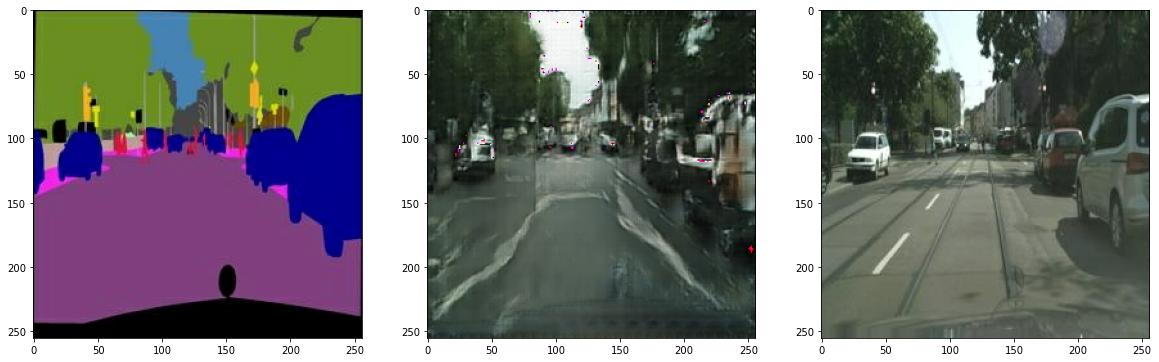

In [ ]:
# 100 epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [38]:
generator.save('./models/generator_100epochs')

INFO:tensorflow:Assets written to: ./models/generator_100epochs/assets


INFO:tensorflow:Assets written to: ./models/generator_100epochs/assets


In [39]:
discriminator.save_weights('./models/discriminator_100epochs')

<br>

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

역시나 시간과의 싸움이었다. 에폭 10일때도 어마어마한 시간이 걸렸는데 100까지 돌리고 난 뒤에는 몇백으로 해야겠다는 생각조차 싹 잊게 만들정도로 한시간 이상은 그냥 넘기게 되는 거 같다. 좀 더 정밀한 이미지를 생성하기 위해서는 그만큼 오래 학습해야하는데 충분한 시간과 하드웨어가 전제되어 있지 않으면 생성조차도 쉽지 않을 것 같다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

처음 노이즈에서부터 시작한 이미지가 점차 segmentation된 이미지까지 구현되어 적용되는 과정을 보는건 꽤 흥미로웠다. 실제 이미지랑 흡사하게 예측하기 위해서는 에폭이 충분해야 하는데, 그 동안의 시간동안에는 추가적인 공부를 하면서 끝나기만을 기다렸던 기억이 난다.

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.                           | 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.<br>                                                        |
| **2** | pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다. | U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.                               |
| **3** | 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.                                    | 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다. |

데이터 증강을 위해서 padding 을 쓰기도 하고 상하반전, 회전과 crop을 이용해서 최대한 다채로운 데이터를 받을 수 있또록 노력했다. 이미지의 경우 해상도나 색감, 선명도에서도 서로 다른 값을 뽑아낼 수 있다고 알고 있는데 이번에는 거기까지 적용하지 못한게 조금 아쉽다.

![다운로드 (2)](https://user-images.githubusercontent.com/100528803/175812027-b1d5a524-bb5c-444d-a64e-7724c64c4686.png)

인코더의 마지막 레이어의 출력을 제외한 뒤에 저장해서 디코더에 각 계층 별 인코더 출력을 함께 입력으로 받았다. U-net 제네레이터 구현과 더불어 discriminator까지 문제없이 돌아가는것을 체크했는데, 각 에폭일때 조금씩 이미지가 다른것을 확인할 수 있었다.

![1111](https://user-images.githubusercontent.com/100528803/175811600-ba605a0f-23b0-4ac1-bf96-a1cb3b8b6ede.png)

이후 처음에 트레인 셋을 생성한 걸 다시 학습했을 때 제대로 생성되서 구현하는 걸 봤을 때는 Gan이라는 모델이 가지는 특성을 하나씩 체크해볼 수 있어서 유의미했던 순간이었다.

<br>

#### ▶️ 자기 다짐

Gan 같은 경우 평소에 부족한 데이터나 이미지들을 제대로 생성한 뒤에 생성한 이미지를 토데로 다시 학습해서 필요한 테스트 데이터를 구분하는 방식으로 현업에서 많이 다루고 있다는 것을 알게 된 후에는 이게 제대로 가능할지 궁금했는데, 직접 해보니까 생가보다 꽤 효율적이라는걸 알 수 있었다.

<br>

## ✔️Reference(참고자료)
---
* https://velog.io/@cha-suyeon/Data-augmentation
* https://deep-learning-study.tistory.com/640
* https://ddongwon.tistory.com/126
* https://hyunlee103.tistory.com/57
* https://blog.naver.com/PostView.naver?blogId=winddori2002&logNo=222111458214